In [3]:
#importing the required lib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import warnings

from keras.layers import Input,Embedding,Flatten ,Dot, Dense, Concatenate
from keras.models import Model

warnings.filterwarnings('ignore')
%matplotlib inline

from sklearn.model_selection import train_test_split

from keras.models import load_model

### Data
Anime.csv

    anime_id - myanimelist.net's unique id identifying an anime.
    name - full name of anime.
    genre - comma separated list of genres for this anime.
    type - movie, TV, OVA, etc.
    episodes - how many episodes in this show. (1 if movie).
    rating - average rating out of 10 for this anime.
    members - number of community members that are in this anime's "group".

Rating.csv

    user_id - non identifiable randomly generated user id.
    anime_id - the anime that this user has rated.
    rating - rating out of 10 this user has assigned (-1 if the user watched it but didn't assign a rating).


In [4]:
#loading the data
dataset= pd.read_csv(r'./data/rating.csv')
#droppin those rows where rating=-1
dataset = dataset.drop(dataset[dataset['rating']==-1].index)
print(dataset.rating.unique())
dataset.head()

[10  8  6  9  7  3  5  4  1  2]


,user_id,anime_id,rating
47,1,8074,10
81,1,11617,10
83,1,11757,10
101,1,15451,10
153,2,11771,10


In [5]:
dataset.shape

(6337241, 3)

In [6]:
#spliting the dataset
train, test = train_test_split(dataset, test_size=0.2,random_state=63)
train.head()

,user_id,anime_id,rating
6533516,60352,7720,8
3633752,33859,13161,9
506416,5137,2789,5
2426129,23166,5507,8
6804604,63005,24833,8


In [7]:
test.head()

,user_id,anime_id,rating
2114652,20480,3503,6
649908,6217,142,10
3687215,34462,11737,6
7141,80,4970,10
794837,7347,10378,7


In [8]:
#unique users and anime
n_users = len(dataset.user_id.unique())
print(n_users)
n_animes = len(dataset.anime_id.unique())
n_animes

69600


9927

* An embedding is a mapping from discrete objects, such as words or ids of anime in our case, to a vector of continuous values. This can be used to find similarities between the discrete objects, that wouldn’t be apparent to the model if it didn’t use embedding layers.

In [9]:
#creating neural netwok
#creating anime embedding path
anime_input =Input(shape=[1] , name='anime-input')
anime_embedding =Embedding(n_animes+1, 10, name="anime-embedding")(anime_input)
anime_vec =Flatten(name='flatten-anime')(anime_embedding)

#creating users embedding path
user_input =Input(shape=[1],name='user-input')
user_embedding =Embedding(n_users+1, 10, name='user-embedding')(user_input)
user_vec =Flatten(name='flatten-user')(user_embedding)

#concatenate features
conc= Concatenate()([anime_vec,user_vec])

#add fully-connected layers
fc1= Dense(128, activation='relu')(conc)
fc2= Dense(64, activation='relu')(fc1)
fc3= Dense(64, activation='relu')(fc2)
fc4= Dense(32, activation='relu')(fc3)
out= Dense(1)(fc4)

#creating model and compiling it
model= Model([user_input,anime_input],out)
model.compile('adam', 'mean_squared_error')

Epoch 1/3
5069792/5069792 [==============================] - 1736s 342us/step - loss: 1.7307
Epoch 2/3
5069792/5069792 [==============================] - 1731s 342us/step - loss: 1.5929
Epoch 3/3
5069792/5069792 [==============================] - 1734s 342us/step - loss: 1.5531


Text(0,0.5,'Training Error')

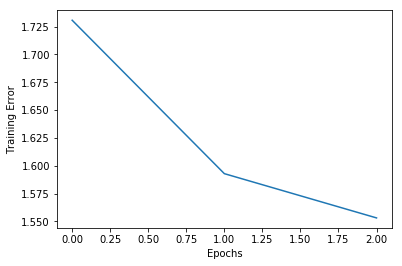

In [10]:
#training
history= model.fit([train.user_id, train.anime_id], train.rating, epochs=3, verbose=1)
model.save('model.h5')
plt.plot(history.history['loss'])
plt.xlabel('Epochs')
plt.ylabel('Training Error')

In [11]:
#evaluating on test data
model.evaluate([test.user_id, test.anime_id], test.rating)

1267449/1267449 [==============================] - 90s 71us/step


1.5822846000754132

In [12]:
#making predictions
predictions= model.predict([test.user_id.head(10), test.anime_id.head(10)])
[print(predictions[i], test.rating.iloc[i]) for i in range(0,10)]

[7.2003818] 6
[8.875046] 10
[6.5667863] 6
[8.801081] 10
[9.749288] 7
[7.4129863] 8
[8.411077] 8
[8.325103] 8
[8.822989] 7
[7.1676393] 7


[None, None, None, None, None, None, None, None, None, None]

#### Making recommendations

In [13]:
#creating dataset for making recommendations for the first user
anime_data = np.array(list(set(dataset.anime_id)))
anime_data[:5]

array([32768,     1,     5,     6,     7], dtype=int64)

In [14]:
user = np.array([1 for i in range(len(anime_data))])
user[:5]

array([1, 1, 1, 1, 1])

In [15]:
#making predictions
predictions = model.predict([user,anime_data])
pred = np.array([a[0] for a in predictions])

#sorting recommended book_id from highly recommended to lowest on basis of score
recommended_anime_ids = (-pred).argsort()[:5]
recommended_anime_ids

array([ 785, 4095, 5749, 2746,  880], dtype=int64)

In [16]:
#predicted scores
pred[recommended_anime_ids]

array([9.560907, 9.553313, 9.533873, 9.513358, 9.512023], dtype=float32)

In [17]:
#reading the anime data
anime = pd.read_csv(r'./data/anime.csv')
anime.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [18]:
#recommended animes
anime[anime['anime_id'].isin(recommended_anime_ids)]

,anime_id,name,genre,type,episodes,rating,members
1076,880,Aa! Megami-sama!: Sorezore no Tsubasa,"Comedy, Magic, Romance, Seinen, Supernatural",TV,22,7.69,42026
2587,785,Otaku no Video,"Comedy, Drama, Historical, Magic, Mecha, Sci-Fi",OVA,2,7.22,13885
3280,2746,Vexille: 2077 Nihon Sakoku,"Action, Military, Sci-Fi",Movie,1,7.04,14754
5921,4095,Chuumon no Ooi Ryouriten (1991),"Fantasy, Horror, Supernatural",Movie,1,6.31,2304
